# Online Adapt

PLDA는 느려서 아직 구현 못함.

너무 성능이 떨어지는 embedding을 사용하면 제대로 adaptation이 일어나지 못한다.

In [1]:
%load_ext autoreload
%autoreload 2
%pylab
%matplotlib inline

import os
import sys
import pandas as pd
import pickle
import numpy as np

Using matplotlib backend: TkAgg
Populating the interactive namespace from numpy and matplotlib


In [2]:
from batch_sv_system_utils import get_embeds, cosine_sim, compute_error
from batch_sv_system_utils import compute_eer
from utils import key2df, df2dict

In [3]:
def get_id2idx(keys):
    key_df = key2df(keys)
    id2idx, idx2id = df2dict(key_df) 
    return id2idx

In [4]:
# https://stackoverflow.com/questions/9110837/python-simple-list-merging-based-on-intersections
def merge(lsts):
    sets = [set(lst) for lst in lsts if lst]
    merged = True
    while merged:
        merged = False
        results = []
        while sets:
            common, rest = sets[0], sets[1:]
            sets = []
            for x in rest:
                if x.isdisjoint(common):
                    sets.append(x)
                else:
                    merged = True
                    common |= x
            results.append(common)
        sets = results
    return [list(set_) for set_ in sets]

In [5]:
embed_dir = "embeddings/voxc2_fbank64_voxc2untied_embeds/"
# embed_dir = "embeddings/voxc2_fbank64_voxc2untied_300f_embeds/"
sv_embeds = np.load(embed_dir + "/sv_embeds.npy")
keys = pickle.load(open(embed_dir + "/sv_keys.pkl", "rb"))
id2idx = get_id2idx(keys)

plda_embed_dir = "embeddings/voxc2_fbank64_voxc2untied_xvector/"
# plda_embed_dir = "embeddings/voxc2_fbank64_voxc2untied_300f_xvector/"
plda_sv_embeds = np.load(plda_embed_dir + "/sv_embeds.npy")
plda_model_dir = plda_embed_dir + "plda_train/"
plda_keys = pickle.load(open(plda_embed_dir + "/sv_keys.pkl", "rb"))
plda_id2idx = get_id2idx(plda_keys)

## Run Trial - Score fusion

In [7]:
trial = pickle.load(open("trials/enr306/eval_hard_enr10_n1000/trials.pkl", "rb"))
cohort_embeds = np.load("trials/enr306/cohort_embeds.npy")

In [8]:
def s_norm_score(scores, enr_mu, enr_std, test_mu, test_std):
    norm_scores = ((scores - enr_mu)/enr_std +\
                   (scores - test_mu)/test_std)/2
    return norm_scores
    
def compute_stat(embeds):
    mu = np.mean(embeds)
    std = np.std(embeds)
    return mu, std

In [17]:
from sklearn.linear_model import LogisticRegressionCV

t_idx = 0
# enr_spk, enr_ids, test_trial, adapt_trial, ood_trial = trial[t_idx]
# test_trial = list(test_trial)
# test_trial[0] = test_trial[0] + ood_trial[0]
# test_trial[1] = test_trial[1] + ood_trial[1]

enr_spk, imposters, enr_ids, test_trial= trial[t_idx]

### get embeds
enr_embeds = get_embeds(enr_ids, sv_embeds, id2idx, norm=True)
test_embeds = get_embeds(test_trial[0], sv_embeds, id2idx, norm=True)

score_list = []
score_fusions = []
norm_score_list = []
norm_score_fusions = []
norm_oracle_score_fusions = []

neg_score_fusions = []
neg_enroll_embeds = []
neg_clusters = []
neg_enroll_ids = []
neg_enroll_mu = []
neg_enroll_std = []

enroll_embeds = [enr for enr in enr_embeds]
enroll_mu = []
enroll_std = []

enr_cohort_scores = cosine_sim(np.array(enroll_embeds), cohort_embeds)
enr_mean = enr_cohort_scores.mean(1)
enr_std = enr_cohort_scores.std(1)
enroll_mu.extend(enr_mean.tolist())
enroll_std.extend(enr_std.tolist())

enroll_stamps = np.zeros(len(test_trial[0]))
neg_enroll_stamps = np.zeros(len(test_trial[0]))

enroll_correct = []
neg_enroll_correct = []

ths = 4.25
preds = []
neg_preds = []

# test_trial = (test_trial[0][200:], test_trial[1][200:])
# for t, in_embed in enumerate(test_embeds[200:]):
for t, in_embed in enumerate(test_embeds):
    test_cohort_scores = cosine_sim(in_embed.reshape(1,-1), cohort_embeds)
    test_mean = test_cohort_scores.mean(1)
    test_std = test_cohort_scores.std(1)

    if len(enroll_embeds) < 10:
        scores = cosine_sim(np.array(enroll_embeds), in_embed)
        norm_scores = ((scores - np.array(enroll_mu))/np.array(enroll_std) + (scores - test_mean)/test_std)/2
    else:
        scores = cosine_sim(np.array(enroll_embeds)[-3:], in_embed)
        enroll_mu_ = np.array(enroll_mu)[-3:]
        enroll_std_ = np.array(enroll_std)[-3:]
        norm_scores = ((scores - enroll_mu_)/enroll_std_ + (scores - test_mean)/test_std)/2
        
    score_fusion = scores.mean(0)
    norm_score_fusion = norm_scores.mean(0)
#     norm_score_fusion = np.median(norm_scores)

    if test_trial[1][t] == 1:
        norm_oracle_score_fusion = norm_scores.max(0)
    else:
        norm_oracle_score_fusion = norm_scores.min(0)
    
    # record scores
    score_list.append(scores)
    norm_score_list.append(norm_scores)
    score_fusions.append(score_fusion)
    norm_score_fusions.append(norm_score_fusion)
    norm_oracle_score_fusions.append(norm_oracle_score_fusion)
    
    # neg scores
    if len(neg_clusters) > 3:
        neg_scores = cosine_sim(np.array(neg_enroll_embeds), in_embed)
        neg_mu = np.array(neg_enroll_mu)
        neg_std = np.array(neg_enroll_std)
        norm_neg_scores = ((neg_scores - neg_mu)/neg_std +\
                           (neg_scores - test_mean)/test_std)/2
        cluster_scores = []
        for cluster in neg_clusters:
            if len(cluster) < 3: continue
            cluster_scores.append(norm_neg_scores[cluster].mean(0))
        try:
            if np.max(cluster_scores) > 5.0:
                neg_score_fusion = norm_score_fusion - np.max(cluster_scores)
#                 if test_trial[1][t] == 1:
#                     print("wrong negative verification:{:.4f}".format(np.max(cluster_scores)))
#                 if test_trial[1][t] == 0 and :
#                     print("correct negative verification:{:.4f}".format(np.max(cluster_scores)))
            else:
                neg_score_fusion = norm_score_fusion
        except ValueError:
            neg_score_fusion = norm_score_fusion
        neg_score_fusions.append(neg_score_fusion)
    else:
        neg_score_fusions.append(norm_score_fusion)
        
    # adaptation
#     if norm_score_fusion > (4.25 - len(enroll_embeds)*0.002) : # enr adapt
    if norm_score_fusion > 4.5:
#     if test_trial[1][t] == 1 and t < 200 and norm_score_fusion > 3.67 and norm_score_fusion < 3.8: # oracle enr adapt
#     if test_trial[1][t] == 1:
#     if t < 200 and norm_score_fusion > 4.5: # oracle enr adapt
        if test_trial[1][t] == 1:
            enroll_correct += [1]
        else:
            enroll_correct += [0]
        enroll_embeds.append(in_embed)
        enr_cohort_scores = cosine_sim(in_embed, cohort_embeds)
        enr_mean = enr_cohort_scores.mean(0)
        enr_std = enr_cohort_scores.std(0)
        enroll_mu.append(enr_mean)
        enroll_std.append(enr_std)
        enroll_stamps[t] = 1
    elif norm_score_fusion < 2.4: # neg adapt
        if test_trial[1][t] == 0:
            neg_enroll_correct += [1]
        else:
            neg_enroll_correct += [0]
        
        if len(neg_enroll_embeds) > 0:
            neg_scores = cosine_sim(np.array(neg_enroll_embeds), in_embed)
            neg_mu = np.array(neg_enroll_mu)
            neg_std = np.array(neg_enroll_std)
            neg_norm_scores = ((neg_scores - neg_mu)/neg_std +\
                               (neg_scores - test_mean)/test_std)/2
            if neg_norm_scores.max() > 5.36:
                close_idx = neg_norm_scores.argmax()
                neg_clusters.append([close_idx, len(neg_enroll_embeds)])
                neg_clusters = merge(neg_clusters)
            
        neg_enroll_ids.append(test_trial[0][t])
        neg_enroll_embeds.append(in_embed)
        enr_cohort_scores = cosine_sim(in_embed, cohort_embeds)
        enr_mean = enr_cohort_scores.mean(0)
        enr_std = enr_cohort_scores.std(0)
        neg_enroll_mu.append(enr_mean)
        neg_enroll_std.append(enr_std)
        
        neg_enroll_stamps[t] = 1

In [22]:
score_list[0]

array([0.6332692 , 0.71036583, 0.6595795 ], dtype=float32)

In [19]:
neg_score_fusions = np.array(neg_score_fusions)
norm_score_fusions = np.array(norm_score_fusions)

init_score_fusions = [score[0] for score in score_list]
init_eer = compute_eer(init_score_fusions, test_trial[1])
adapt_eer = compute_eer(score_fusions, test_trial[1])
norm_adapt_eer = compute_eer(norm_score_fusions, test_trial[1])
oracle_norm_adapt_eer = compute_eer(norm_oracle_score_fusions, test_trial[1])
neg_eer = compute_eer(neg_score_fusions, test_trial[1])
print("adapt_enr:{}({:.2f}), neg_enr:{}({:.2f})".format(len(enroll_embeds)-3, np.mean(enroll_correct),
                                                        len(neg_enroll_embeds), np.mean(neg_enroll_correct)))
print("init_eer:{:.4f}, adapt_eer:{:.4f} ".format(init_eer[0], adapt_eer[0]) +  
      "norm_adapt_eer:{:.4f}, norm_oracle_adapt_eer:{:.4f}, neg_eer:{:.4f}".format(
    norm_adapt_eer[0], oracle_norm_adapt_eer[0], neg_eer[0]))

ValueError: bad input shape (1992, 3)

In [ ]:
print(enr_spk)
print(imposters)
for cluster in neg_clusters:
    print(np.array(neg_enroll_ids)[cluster])

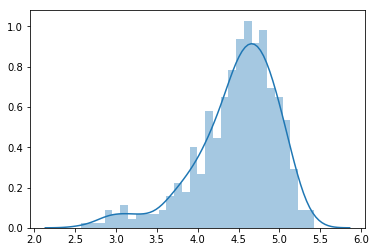

In [775]:
import seaborn as sns
sns.distplot(norm_score_fusions[test_trial[1]==1], bins=30, kde=True)

In [320]:
print(norm_adapt_eer[-1])
norm_score_fusions[(norm_score_fusions < norm_adapt_eer[-1]) & (test_trial[1] == 1)]

3.8318372


array([3.2148209, 3.5494711, 3.436107 , 3.787942 , 3.7652142, 3.6931164,
       3.7878513, 3.4466853, 3.3797152, 3.3289247, 3.210183 , 2.9737775],
      dtype=float32)

/opt/conda/envs/pytorch-py3.6/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


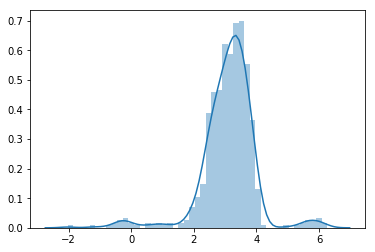

In [448]:
neg_score_fusions = np.array(neg_score_fusions)
sns.distplot(neg_score_fusions[test_trial[1] == 1])

/opt/conda/envs/pytorch-py3.6/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


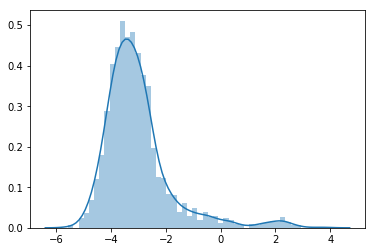

In [449]:
neg_score_fusions = np.array(neg_score_fusions)
sns.distplot(neg_score_fusions[test_trial[1] == 0])

In [168]:
from sklearn.cluster import KMeans
model = KMeans(n_clusters=4, init="random", n_init=10, max_iter=300, random_state=8).fit(np.array(neg_enroll_embeds))